In [1]:
import numpy as np
import h5py
import os
from random import shuffle
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import matplotlib.pyplot as plt
import argparse
from distilled_model import *
#, create_quantized_distilled_model, create_extra_small_quantized_distilled_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import yaml
import math
import tqdm as notebook_tqdm
import hls4ml

2022-06-20 16:03:39.706509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 16:03:39.714853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 16:03:39.715275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/home/ferroelectric/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
img = np.load('./02_scan_x256_y256_raw.npy')

In [4]:
img.shape

(124, 124, 256, 256)

In [5]:
img = np.transpose(img,(2,3,0,1)) 
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r) 
max_ = np.max(data_r) 
data_r = 1.0*(data_r-min_)/(max_-min_)
data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122] 
data_r_cut = data_r_cut.reshape(256,256,120,120) 
data_r_cut = np.rot90(data_r_cut)  
X = data_r_cut.reshape(-1, 120,120)

In [6]:
X.shape

(65536, 120, 120)

In [7]:
# generate outputs/targets
dataset_h5 = h5py.File('./unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)

In [8]:
y.shape
print(y[0])

[0.94005179 0.34103164 1.12650526 0.         0.         1.19970393]


In [9]:
#y = np.load('unbinned_results.npy')
sc = StandardScaler()
y_scal = sc.fit_transform(y)

In [10]:
y_scal.shape

(65536, 6)

In [11]:
precision = 12
MODEL = create_mlp_avg_pool(precision)
optimizer = 'adam'
loss = 'mse'

stopping = EarlyStopping(monitor='val_loss',
                             patience = 10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                  mode='min', verbose=1, min_delta=0.001,
                                  cooldown=4, min_lr=1e-5)
callbacks=[
        stopping,
        reduce_lr,
    ]

2022-06-20 16:03:49.064727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 16:03:49.066628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 16:03:49.066954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 16:03:49.067204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
MODEL.compile(optimizer=optimizer, loss=loss,)

In [13]:
MODEL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 average_pooling2d (AverageP  (None, 30, 30, 1)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 q_dense (QDense)            (None, 64)                57664     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 q_activation (QActivation)  (None, 64)                0     

In [14]:
# history = MODEL.fit(X,y_scal,
#                 epochs=115,
#                 batch_size = 32,
#                 shuffle=True,
#                 validation_split = 0.2,)

In [15]:
# history = MODEL.fit(X,y_scal,
#                 epochs=15,
#                 batch_size = 32,
#                 shuffle=True,
#                 validation_split = 0.2,
#                 callbacks=callbacks)

In [16]:
#MODEL.save_weights("./model_weights_switched_batch.h5")

In [17]:
MODEL.load_weights("./model_weights.h5")

In [18]:
os.system('mkdir -p ./keras_figures')
os.system('mkdir -p ./hls_figures')

0

In [19]:
MODEL.save('./model.h5')

In [20]:
try:
    # plot history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training_loss', 'validation_loss'], loc='upper left')
    plt.savefig('./keras_figures/model.png')
except:
    print("Unable to save training history figure")
    
    

Unable to save training history figure


## Convert and post-processing

In [21]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from qkeras.utils import _add_supported_quantized_objects
import argparse
import yaml

In [22]:
#same as before
img = np.load('./02_scan_x256_y256_raw.npy')
img = np.transpose(img,(2,3,0,1))
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r)
max_ = np.max(data_r)

data_r = 1.0*(data_r-min_)/(max_-min_)

data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122]
data_r_cut = data_r_cut.reshape(256,256,120,120)
X = data_r_cut.reshape(-1, 120,120)

In [23]:
print(X.shape)

(65536, 120, 120)


In [24]:
# generate outputs/targets
dataset_h5 = h5py.File('./unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)
sc = StandardScaler()
_ = sc.fit(y)
base_8 = np.load('./base_8.npy', allow_pickle=1)

In [25]:
predictions = MODEL.predict(np.ascontiguousarray(X))
predictions = sc.inverse_transform(predictions)

In [26]:
predictions.shape

In [27]:
print('keras pred: ', predictions[1000])
print('actual:     ', y[1000])

In [28]:
rotation_, scale_ = predictions[:, 0:2], predictions[:, 2:]

mse = np.mean((y - predictions)**2)
print('model MSE on full dataset: ', mse)

#base=2,loss=0.024
j=0
list_new = []
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i in range(2):
    if np.sum(base_8[:,i]!=0):
        j+=1
        print(i)
        list_new.append(i)
        ax[i].title.set_text(str(i))
        ax[i].imshow(base_8[:,i].reshape(256,256))
print('total activated channels: '+str(j))
ax[2].title.set_text('mean of the sample domain')
ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))
fig.savefig('./keras_figures/unknown.png')

fig,ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(rotation_[:,0].reshape(256,256))
ax[0][1].imshow(rotation_[:,1].reshape(256,256))
ax[1][0].hist(rotation_[:,0].reshape(-1),200)
ax[1][1].hist(rotation_[:,1].reshape(-1),200)
fig.savefig('./keras_figures/rotation.png')

In [29]:
sample_base = base_8[:,1].reshape(256,256)

scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

In [30]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
clim0 = [1.14,1.19]
clim1 = [1.1,1.17]
ax[0][0].imshow(scale_0,clim=clim0)
ax[0][1].imshow(scale_1,clim=clim1)
ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
fig.savefig('./keras_figures/scale.png')


right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)
np.save('./keras_figures/right_triangle_mlp_average_pool_12b.npy', right_tri)
fig,ax = plt.subplots(1,2,figsize=(20,10))
clim=[1.59,1.65]
ax[0].imshow(right_tri,clim=clim)
ax[1].hist(right_tri.reshape(-1),200,range=clim)
fig.savefig('./keras_figures/right_triangle.png')

## Now Test HLS Model

In [31]:
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [301]:
config = hls4ml.utils.config_from_keras_model(MODEL, granularity='name')
REUSE_FACTOR = 16
config['Model']['ReuseFactor'] = REUSE_FACTOR
# config['SkipOptimizers'] = ['reshape_stream']
config['SkipOptimizers']= ['relu_merge']
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<18,6>'
config['OutputDir'] = '.'
#config['Model']['Compression'] = 'True'


for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
    config['LayerName'][layer]['ReuseFactor'] = REUSE_FACTOR

config['LayerName']['q_dense']['Precision']['weight'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense']['Precision']['bias'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_1']['Precision']['weight'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_1']['Precision']['bias'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_2']['Precision']['weight'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_2']['Precision']['bias'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_3']['Precision']['weight'] = 'ap_fixed<12,4>'
config['LayerName']['q_dense_3']['Precision']['bias'] = 'ap_fixed<12,4>'



# config['LayerName']['q_activation']['Precision'] = 'ap_fixed<16,8, AP_RND,AP_SAT>'

# config['LayerName']['batch_normalization']['Precision'] = 'ap_fixed<16,8>'
# config['LayerName']['batch_normalization_1']['Precision'] = 'ap_fixed<16,8>'
# config['LayerName']['batch_normalization_2']['Precision'] = 'ap_fixed<16,8>'



# config['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<16,8>'
# config['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<16,8,AP_RND,AP_SAT>'

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: average_pooling2d, layer type: AveragePooling2D
Layer name: q_dense, layer type: QDense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_2, layer type: QDense
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense_3, layer type: QDense


In [302]:
print_dict(config)
HLS_MODEL = hls4ml.converters.convert_from_keras_model(MODEL,
                                                    hls_config=config,
                                                    output_dir='./my-hls-test',
                                                    part='xcu200-fsgd2104-2-e',
                                                    io_type='io_stream')
HLS_MODEL.compile()

Model
  Precision:         ap_fixed<18,6>
  ReuseFactor:       16
  Strategy:          Resource
LayerName
  input_1
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
    ReuseFactor:     16
  average_pooling2d
    Precision:       ap_fixed<16,6>
    Trace:           True
    ReuseFactor:     16
  q_dense
    Precision
      weight:        ap_fixed<12,4>
      bias:          ap_fixed<12,4>
    ReuseFactor:     16
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
    ReuseFactor:     16
    Trace:           True
  q_activation
    Precision
      result:        ap_ufixed<8,0>
    ReuseFactor:     16
    Trace:           True
  q_dense_1
    Precision
      weight:        ap_fixed<12,4>
      bias:          ap_fixed<12,4>
    ReuseFactor:     16
    Trace:           True
  batch_normalization_1
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
 

In [ ]:
#same as before
img = np.load('./02_scan_x256_y256_raw.npy')
img = np.transpose(img,(2,3,0,1))
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r)
max_ = np.max(data_r)

data_r = 1.0*(data_r-min_)/(max_-min_)

data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122]
data_r_cut = data_r_cut.reshape(256,256,120,120)
X = data_r_cut.reshape(-1, 120,120)

#Does something, tbd
# generate outputs/targets
dataset_h5 = h5py.File('./unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)
sc = StandardScaler()
_ = sc.fit(y)
base_8 = np.load('./base_8.npy', allow_pickle=1)

predictions = HLS_MODEL.predict(np.ascontiguousarray(X))
predictions = sc.inverse_transform(predictions)

print('hls pred: ', predictions[1000])
print('actual:   ', y[1000])

rotation_, scale_ = predictions[:, 0:2], predictions[:, 2:]

mse = np.mean((y - predictions)**2)
print('hls model MSE on full dataset: ', mse)

#base=2,loss=0.024
j=0
list_new = []
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i in range(2):
    if np.sum(base_8[:,i]!=0):
        j+=1
        print(i)
        list_new.append(i)
        ax[i].title.set_text(str(i))
        ax[i].imshow(base_8[:,i].reshape(256,256))
print('total activated channels: '+str(j))
ax[2].title.set_text('mean of the sample domain')
ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))
fig.savefig('./hls_figures/unknown.png')

fig,ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(rotation_[:,0].reshape(256,256))
ax[0][1].imshow(rotation_[:,1].reshape(256,256))
ax[1][0].hist(rotation_[:,0].reshape(-1),200)
ax[1][1].hist(rotation_[:,1].reshape(-1),200)
fig.savefig('./hls_figures/rotation.png')

sample_base = base_8[:,1].reshape(256,256)

scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

fig,ax = plt.subplots(2,2,figsize = (10,10))
clim0 = [1.14,1.19]
clim1 = [1.1,1.17]
ax[0][0].imshow(scale_0,clim=clim0)
ax[0][1].imshow(scale_1,clim=clim1)
ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
fig.savefig('./hls_figures/scale.png')


right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)
np.save('./hls_figures/right_triangle_mlp_average_pool_12b.npy', right_tri)
fig,ax = plt.subplots(1,2,figsize=(20,10))
clim=[1.59,1.65]
ax[0].imshow(right_tri,clim=clim)
ax[1].hist(right_tri.reshape(-1),200,range=clim)
fig.savefig('./hls_figures/right_triangle.png')

In [303]:
# print(np.amin(np.ascontiguousarray(X)))

## Profiling to Compare Layer Outputs

In [304]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [305]:
from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
import matplotlib.pyplot as plt
import yaml

In [306]:
X_test = np.ascontiguousarray(X)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 120, 120, 1]], output shape: [None, 120, 120, 1]
Layer name: average_pooling2d, layer type: AveragePooling2D, input shapes: [[None, 120, 120, 1]], output shape: [None, 30, 30, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 30, 30, 1]], output shape: [None, 900]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 900]], output shape: [None, 64]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32]], output sha

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

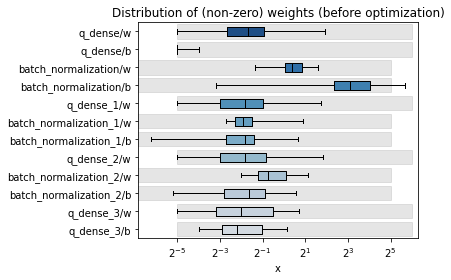

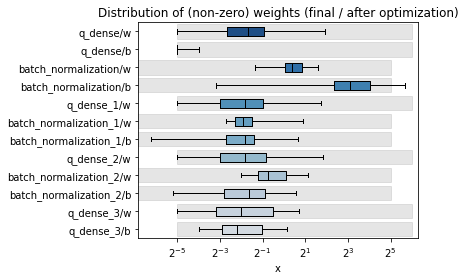

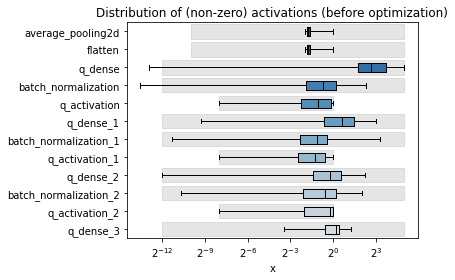

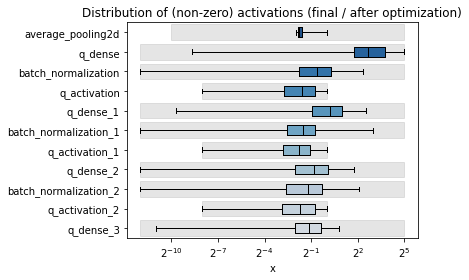

In [307]:
%matplotlib inline
hls4ml.model.profiling.numerical(model=MODEL, hls_model = HLS_MODEL, X=X_test[0:100])

In [308]:
## Trace Model
keras_trace = hls4ml.model.profiling.get_ymodel_keras(MODEL, X_test[0:100])

Processing input_1 in Keras model...
Processing average_pooling2d in Keras model...
Processing flatten in Keras model...
Processing q_dense in Keras model...
Processing batch_normalization in Keras model...
Processing q_activation in Keras model...
Processing q_dense_1 in Keras model...
Processing batch_normalization_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_dense_2 in Keras model...
Processing batch_normalization_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing q_dense_3 in Keras model...
Done taking outputs for Keras model.


In [309]:
y_hls, hls4ml_trace = HLS_MODEL.trace(X_test[0:100])

Recompiling myproject with tracing
Writing HLS project
Done


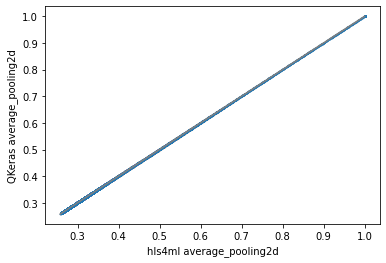

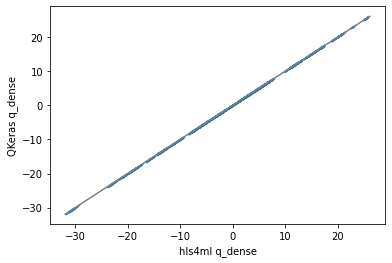

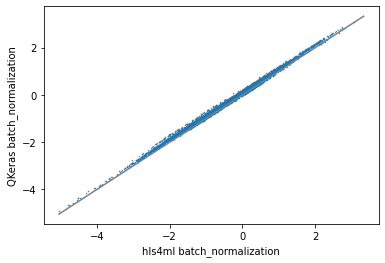

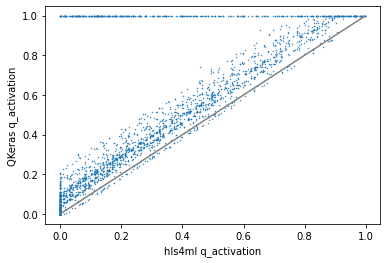

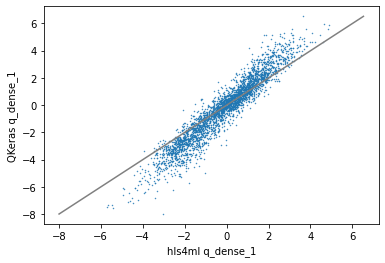

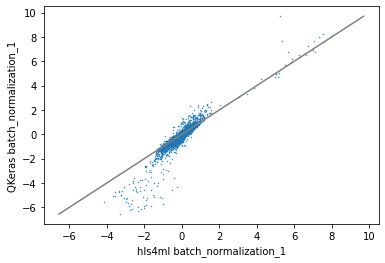

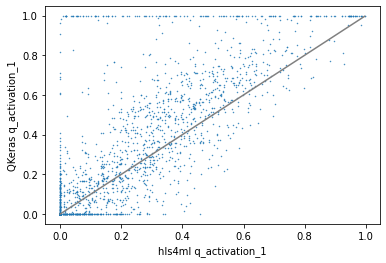

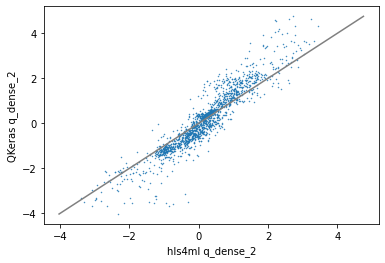

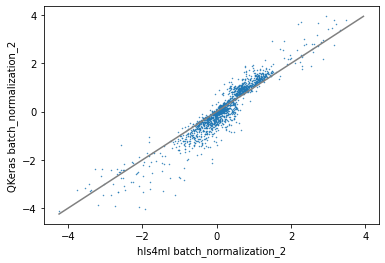

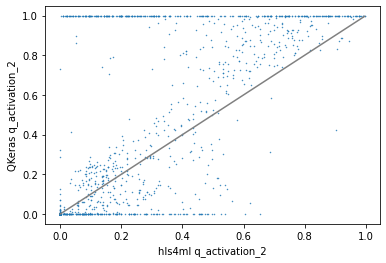

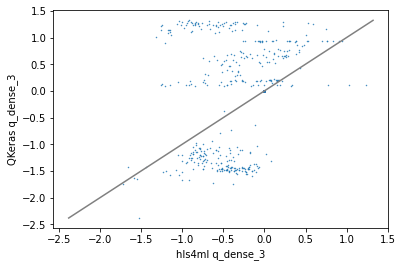

In [310]:
for layer in hls4ml_trace.keys():
            plt.figure()
            klayer = layer
            if '_alpha' in layer:
                klayer = layer.replace('_alpha', '')
            plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
            min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
            max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
            plt.plot([min_x, max_x], [min_x, max_x], c='gray')
            plt.xlabel('hls4ml {}'.format(layer))
            plt.ylabel('QKeras {}'.format(klayer))
            plt.savefig(os.path.join(config['OutputDir'], 'profiling_{}.png'.format(layer)), dpi=300)

## Build Model

In [43]:
# os.environ['PATH'] = '/home/ferroelectric/Xilinx_2020/Vivado/2020.1/bin:' + os.environ['PATH']
# os.environ['PATH'] = '/home/ferroelectric/Xilinx_2020/Vitis/2020.1/bin:' + os.environ['PATH']

In [44]:
# HLS_MODEL.build(csim=False,synth=True, vsynth=True, export=True)

In [45]:
# hls4ml.report.read_vivado_report('./my-hls-test')